<h1 style="text-align:center; font-size:40px"><u>Approximate Gaussian Processes Coding Demo</u></h1>

This coding demo has been adapted from the excellent Gaussian Process Summer School (2018) lab 2 written by _Fariba Yousefi, Juan José Giraldo, and Wil Ward._ You can find the original labs in this <a href="https://github.com/gpschool/gpss18" target="_blank">Github repository</a>.

In this demo, we will go through two methods for approximating Gaussian Processes (GP) regression on a small and large dataset. The first method is the Deterministic Training Conditional (DTC) Approximation and the second method is the stochastic variational GP approximation. We will also be introducing the theory behind optimising for inducing inputs. In our theory demo, we have assumed that the inducing inputs have been provided.

This notebook uses `GPy` for handling the regression model and likelihoods.

##  1. Getting started

You should be using Python 3.5 (or above), and have `GPy` installed.

We will use `numpy` for maths functionality, `pyplot` for plotting, and `GPy` for Gaussian processes. The documentation for `GPy` is available at [gpy.readthedocs.io](http://gpy.readthedocs.io/en/deploy/)

In [25]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline
import time
from scipy.cluster.vq import kmeans
import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

We will use this plotting function to help with visualising our GP regression outputs:

In [26]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)), # 95% confidence interval of a Gaussian is
                     m[:,0] + 1.96*np.sqrt(np.diag(C)), # .. contained within mean +/- 1.96*s.d.
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

## Full versus Sparse Gaussian Process Regression

In the following example, we will simulate some observations sampled from a GP, and compare the results of sparse and full regression.

First we will generate $N=50$ samples from a GP:

In [27]:
# This is important for reproducing the latent function
np.random.seed(40918)

# The covariance in the latent function is an RBF with l=0.2
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1)

# Create a smooth GP latent function
N = 50
X = np.sort(np.random.rand(N, 1), 0)
y = np.random.multivariate_normal(np.zeros(N), k.K(X,X) + 0.01*np.eye(N))[:, None]

While $n=50$ is not a _huge_ number of data, this example will show that we can get a reasonably accurate fit with only a small number of inducing variables, $m=3$. This will reduce the complexity of full GP regression, $\mathscr{O}(n^3)$, to $\mathscr{O}(m^2n)$, which is clearly a useful reduction in computational requirements &ndash; even in this basic example, we can see $n \times m^2 = 450 \ll n^3 = 125000$.

We make use of the `SparseGPRegression` model which, like the `GPRegression` model, has sensible defaults that we don't need to worry about for this example. The `SparseGPRegression` assumes a Gaussian likelihood and uses exact Gaussian inference. We could also define these explicitly using `core.SVGP`, which is the sparse equivalent of `core.GP` that we used above, allowing us to define the inference method, and likelihood.

**We first fit the full GP**

elapsed time: 0.007979393005371094 seconds


Text(0.5, 1.0, 'Full GP regression')

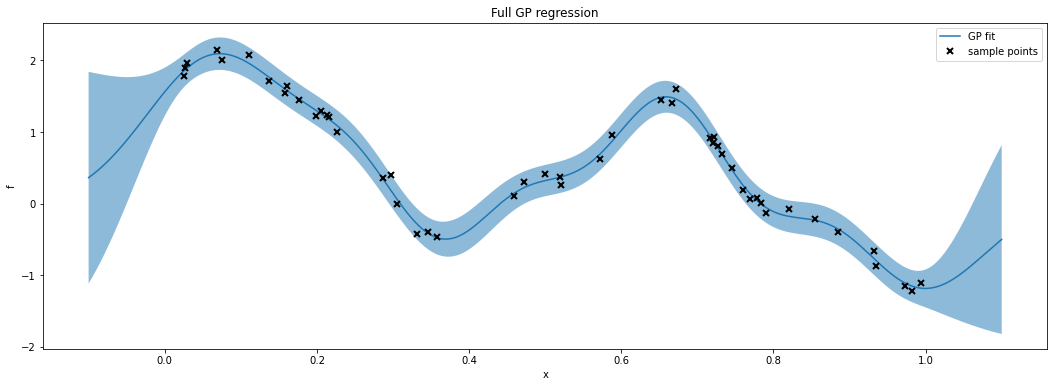

In [28]:
# Our sample space for predictions from the posterior
Xnew = np.linspace(-0.1, 1.1, 1000)[:, None]

# The covariance we used to generate the samples (assumed)
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1)

# Prepare figure enviroment
plt.figure(figsize=(18, 6))

## First we fit with full GP regression
t0 = time.time()
m = GPy.models.GPRegression(X, y, kernel=k)
t1 = time.time()
m.Gaussian_noise.variance = 0.01
print('elapsed time:',t1-t0,'seconds')

# Note we don't even optimise the hyperparameters because they are known here
mean_full, Cov_full = m.predict(Xnew, full_cov=True)

# We plot our regression fit of the likelihood
plot_gp(Xnew, mean_full, Cov_full, training_points=(X, y))
plt.title("Full GP regression")

**Then we fit the sparse GP using DTC and 3 random inducing inputs**

elapsed time: 0.014960765838623047 seconds


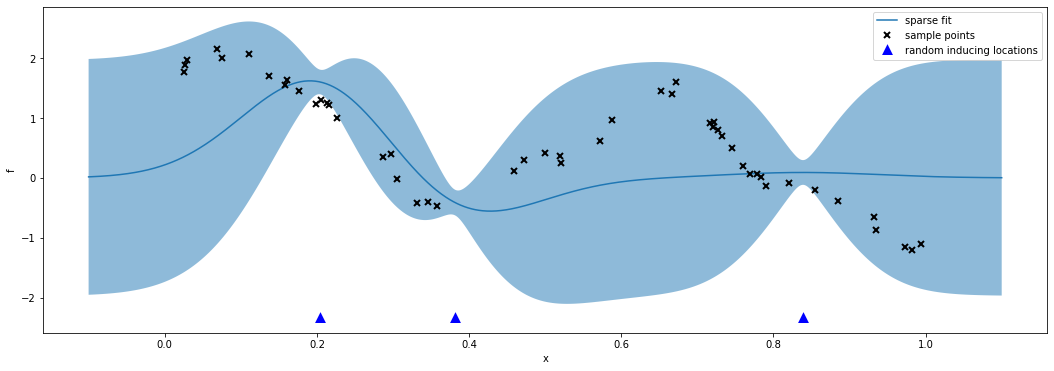

In [29]:
## Next, we define M=3 inducing inputs randomly within the sample space
Z = np.random.rand(3, 1)

# We fit with sparse GP regression using randomly assigned inducing variables
t0 = time.time()
m = GPy.models.SparseGPRegression(X, y, Z=Z, kernel=k)
t1 = time.time()
print('elapsed time:',t1-t0,'seconds')
m.Gaussian_noise.variance = 0.01
m.Gaussian_noise.fix() # We fix the Gaussian observation noise

# We will not optimise any of the hyperparameters again
mean_sparse_rand, Cov_sparse_rand = m.predict(Xnew, full_cov=True)

# Prepare figure enviroment
plt.figure(figsize=(18, 6))
# Plot the posterior of the likelihood fit using a sparse GP
plot_gp(Xnew, mean_sparse_rand, Cov_sparse_rand, training_points=(X, y))
# Plot the randomly assigned inducing variables
plt.plot(Z, [plt.ylim()[0] for _ in Z], 'b^', mew=3)
plt.legend(labels=["sparse fit", "sample points", "random inducing locations"])

**Elapsed time vs number of observed points**<br>
Although it may seem as though the full GP is faster, this is simply because the number of datapoints are very small, lets demonstrate how quickly the elapsed time increases when we increase the number of observed points.

Number of data points: 50 | Full GP elapsed time: 0.0070 seconds | Sparse GP elapsed time: 0.0130 seconds
Number of data points: 60 | Full GP elapsed time: 0.0100 seconds | Sparse GP elapsed time: 0.0110 seconds
Number of data points: 70 | Full GP elapsed time: 0.0080 seconds | Sparse GP elapsed time: 0.0100 seconds
Number of data points: 80 | Full GP elapsed time: 0.0060 seconds | Sparse GP elapsed time: 0.0100 seconds
Number of data points: 90 | Full GP elapsed time: 0.0060 seconds | Sparse GP elapsed time: 0.0110 seconds
Number of data points: 101 | Full GP elapsed time: 0.0090 seconds | Sparse GP elapsed time: 0.0110 seconds
Number of data points: 111 | Full GP elapsed time: 0.0100 seconds | Sparse GP elapsed time: 0.0130 seconds
Number of data points: 121 | Full GP elapsed time: 0.0120 seconds | Sparse GP elapsed time: 0.0120 seconds
Number of data points: 131 | Full GP elapsed time: 0.0130 seconds | Sparse GP elapsed time: 0.0110 seconds
Number of data points: 142 | Full GP elaps

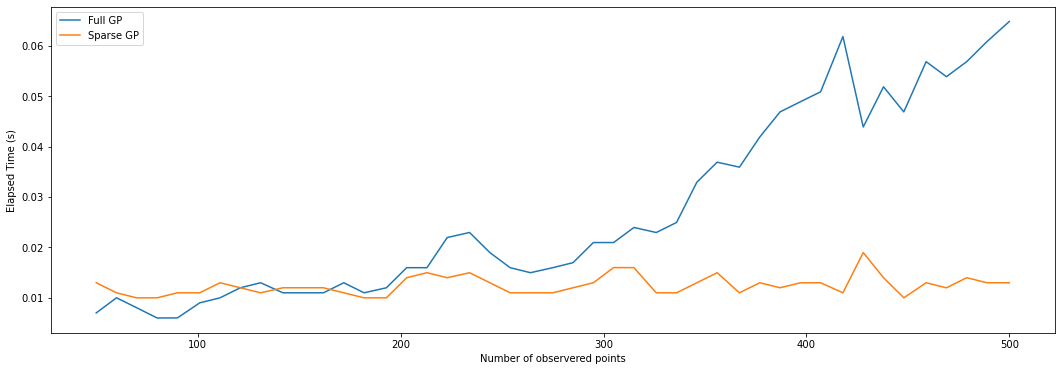

In [30]:
# This is important for reproducing the latent function
np.random.seed(40918)
N = np.linspace(50, 500, 45, dtype=int)
gp_full_time = np.zeros(len(N))
gp_sparse_time = np.zeros(len(N))

for i in range(len(N)):
    X = np.sort(np.random.rand(N[i], 1), 0)
    y = np.random.multivariate_normal(np.zeros(N[i]), k.K(X,X) + 0.01*np.eye(N[i]))[:, None]
    
    ## First we fit with full GP regression
    t0_full = time.time()
    m = GPy.models.GPRegression(X, y, kernel=k)
    t1_full = time.time()
    gp_full_time[i] = t1_full - t0_full
    
    ## Now we fit with sparse GP regression
    t0_sparse = time.time()
    m = GPy.models.SparseGPRegression(X, y, Z=Z, kernel=k)
    t1_sparse = time.time()
    gp_sparse_time[i] = t1_sparse - t0_sparse
    
    print('Number of data points:',N[i],'| Full GP elapsed time: %.4f seconds | Sparse GP elapsed time: %.4f seconds'% (gp_full_time[i], gp_sparse_time[i]))

# We can plot this
# Prepare figure enviroment
plt.figure(figsize=(18, 6))
line_full, = plt.plot(N,gp_full_time,label="Full GP")
line_sparse, = plt.plot(N,gp_sparse_time,label="Sparse GP")
plt.legend(handles=[line_full, line_sparse])
plt.xlabel("Number of observered points")
plt.ylabel("Elapsed Time (s)")
plt.show()

**Elapsed time vs number of induced points**<br>
It is clear from the above figure that elapsed time to fit a full GP model increases rapidly with an increasing number of observed points. On the other hand, the elapsed time to fit a sparse GP model does not increase up to 500 observed points. Recall that the computational complexity to fit a GP model using DTC is $\mathscr{O}(m^2n)$ therefore, we will demonstrate how the elapsed time to fit a sparse GP model increases with an increasing number of inducing inputs and a fixed number of input points.

Sparse GP elapsed time with 1 inducing inputs is: 0.0140 seconds
Sparse GP elapsed time with 3 inducing inputs is: 0.0120 seconds
Sparse GP elapsed time with 5 inducing inputs is: 0.0120 seconds
Sparse GP elapsed time with 7 inducing inputs is: 0.0140 seconds
Sparse GP elapsed time with 9 inducing inputs is: 0.0150 seconds
Sparse GP elapsed time with 11 inducing inputs is: 0.0140 seconds
Sparse GP elapsed time with 13 inducing inputs is: 0.0160 seconds
Sparse GP elapsed time with 15 inducing inputs is: 0.0150 seconds
Sparse GP elapsed time with 17 inducing inputs is: 0.0140 seconds
Sparse GP elapsed time with 19 inducing inputs is: 0.0140 seconds
Sparse GP elapsed time with 21 inducing inputs is: 0.0140 seconds
Sparse GP elapsed time with 23 inducing inputs is: 0.0120 seconds
Sparse GP elapsed time with 25 inducing inputs is: 0.0090 seconds
Sparse GP elapsed time with 27 inducing inputs is: 0.0100 seconds
Sparse GP elapsed time with 29 inducing inputs is: 0.0090 seconds
Sparse GP elaps

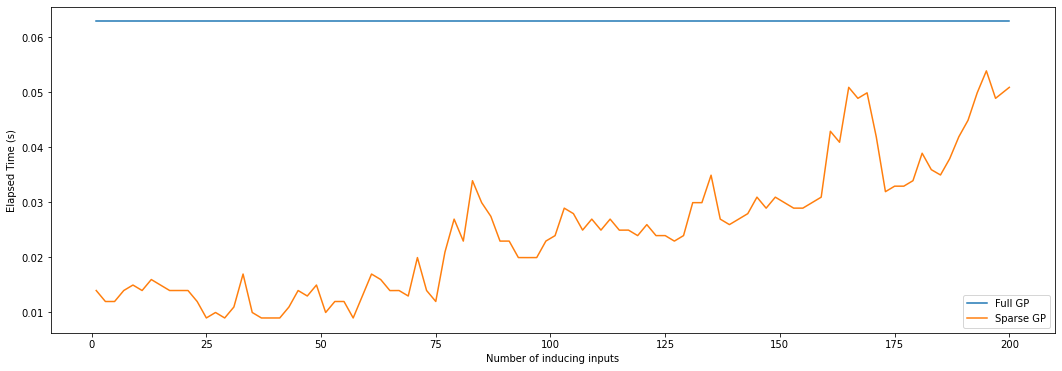

In [31]:
# This is important for reproducing the latent function
np.random.seed(40918)
N = 500
M = np.linspace(1, 200, 100, dtype=int)
gp_sparse_time = np.zeros(len(M))

X = np.sort(np.random.rand(N, 1), 0)
y = np.random.multivariate_normal(np.zeros(N), k.K(X,X) + 0.01*np.eye(N))[:, None]

## First we fit with full GP regression
t0_full = time.time()
m = GPy.models.GPRegression(X, y, kernel=k)
t1_full = time.time()
gp_full_time = t1_full - t0_full
    
for i in range(len(M)):
    
    ## Now we fit with sparse GP regression
    t0_sparse = time.time()
    m = GPy.models.SparseGPRegression(X, y, Z=np.random.rand(M[i], 1), kernel=k)
    t1_sparse = time.time()
    gp_sparse_time[i] = t1_sparse - t0_sparse
    
    print('Sparse GP elapsed time with %s inducing inputs is: %.4f seconds'% (M[i], gp_sparse_time[i]))

# We can plot this
# Prepare figure enviroment
plt.figure(figsize=(18, 6))
line_full, = plt.plot(M,[gp_full_time]*len(M),label="Full GP")
line_sparse, = plt.plot(M,gp_sparse_time,label="Sparse GP")
plt.legend(handles=[line_full, line_sparse])
plt.xlabel("Number of inducing inputs")
plt.ylabel("Elapsed Time (s)")
plt.show()

## Optimising for inducing inputs
As seen from the figure above, the elapsed time to fit a sparse GP model increases quickly with an increasing number of inducing inputs. In this example, we would like to argue that 3 inducing inputs provides a reasonably accurate fit. However, looking at the plot of the initial sparse GP model with 3 inducing inputs the model fit is no where near that of the full GP model. This is because we have not optimised the location of the inducing inputs, $X_{\mathbf{u}}$. <br>
As per the research paper [1], many methods have been proposed to optimise for the location of the inducing inputs. Traditionally, this will be a carefully chosen subset of the training points. However, choosing inducing inputs as a subset of the testing points have also been proposed. The way in which we shall demonstrate optimisation of inducing inputs for DTC is firstly by **relaxing the constraint that the inducing inputs must be a subset of training/test points** and **maximising the marginal likelihood with respect to the inducing inputs, $X_{\mathbf{u}}$, through computing gradients**.<br>
The approximate methods proposed in [1] (SoR, DTC, FITC, PITC) have different effective priors and therefore different effective marginal likelihood conditioned on $X_{\mathbf{u}}$:
$$q(\mathbf{y}|X_{\mathbf{u}}) = \int \int p(\mathbf{y}|\mathbf{f}) \; p(\mathbf{f}|\mathbf{u}) \; p(\mathbf{u}|X_{\mathbf{u}}) \; d\mathbf{u} \; d\mathbf{f} = \int p(\mathbf{y}|\mathbf{f}) \; p(\mathbf{f}|X_{\mathbf{u}})\; d\mathbf{u} \; d\mathbf{f} $$
We can then use Gaussian Identities to find the marginal likelihood of each approximation method. The general form of the log marginal likelihood for each approximation method is as follows:
$$\text{log}\;q(\mathbf{y}|X_{\mathbf{u}}) = -\frac{1}{2} \text{log}\; |Q_{\mathbf{f},\mathbf{f}} + \Lambda| - \frac{1}{2} \mathbf{y}^T (Q_{\mathbf{f},\mathbf{f}} + \Lambda)^{-1}\mathbf{y} - \frac{n}{2}\text{log}\;(2 \pi)$$
Where: <br>
$\Lambda_{SoR} = \Lambda_{DTC} = \sigma^2_{\text{noise}}I$ <br>
$\Lambda_{FITC} = diag[K_{\mathbf{f},\mathbf{f}} - Q_{\mathbf{f},\mathbf{f}}] + \sigma^2_{\text{noise}}I$ <br>
$\Lambda_{PITC} = blockdiag[K_{\mathbf{f},\mathbf{f}} - Q_{\mathbf{f},\mathbf{f}}] + \sigma^2_{\text{noise}}I$ <br>

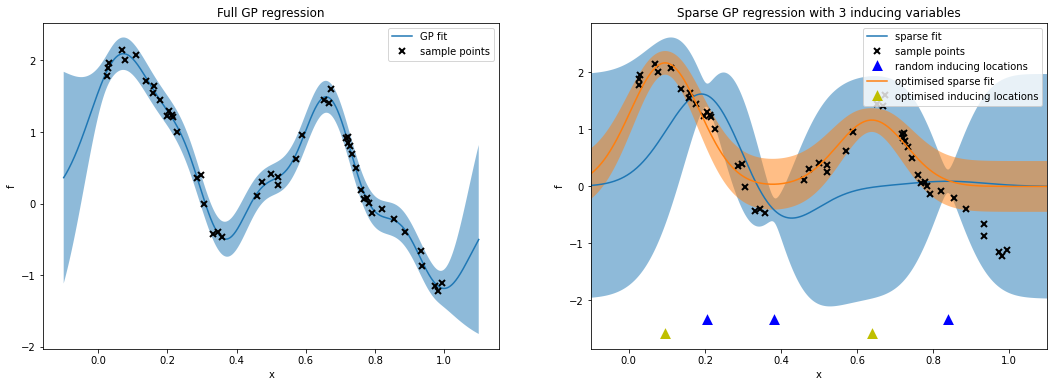

In [32]:
# This is important for reproducing the latent function
np.random.seed(40918)

# The covariance in the latent function is an RBF with l=0.2
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1)

# Create a smooth GP latent function
N = 50
X = np.sort(np.random.rand(N, 1), 0)
y = np.random.multivariate_normal(np.zeros(N), k.K(X,X) + 0.01*np.eye(N))[:, None]

# Our sample space for predictions from the posterior
Xnew = np.linspace(-0.1, 1.1, 1000)[:, None]

# The covariance we used to generate the samples (assumed)
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1)

# Prepare figure enviroment
plt.figure(figsize=(18, 6))

plt.subplot(121)
## First we fit with full GP regression 
m = GPy.models.GPRegression(X, y, kernel=k)
m.Gaussian_noise.variance = 0.01

# Note we don't even optimise the hyperparameters because they are known here
mean_full, Cov_full = m.predict(Xnew, full_cov=True)

# We plot our regression fit of the likelihood
plot_gp(Xnew, mean_full, Cov_full, training_points=(X, y))
plt.title("Full GP regression")
plt.subplot(122)

## Next, we define M=3 inducing inputs randomly within the sample space
Z = np.random.rand(3, 1)

# We fit with sparse GP regression using randomly assigned inducing variables
m = GPy.models.SparseGPRegression(X, y, Z=Z, kernel=k)
m.Gaussian_noise.variance = 0.01
m.Gaussian_noise.fix() # We fix the Gaussian observation noise

# We will not optimise any of the hyperparameters again
mean_sparse_rand, Cov_sparse_rand = m.predict(Xnew, full_cov=True)

# Plot the posterior of the likelihood fit using a sparse GP
plot_gp(Xnew, mean_sparse_rand, Cov_sparse_rand, training_points=(X, y))
# Plot the randomly assigned inducing variables
plt.plot(Z, [plt.ylim()[0] for _ in Z], 'b^', mew=3)
         
## We are now going to optimise the model
# We will optimise the inducing inputs locations and the 
# .. kernel hyperparameters with respect to each other (remember the noise is fixed)
m.optimize()

# We predict the optimised sparse GP fit
mean_sparse_opt, Cov_sparse_opt = m.predict(Xnew, full_cov=True)

# We plot our new mean
plot_gp(Xnew, mean_sparse_opt, Cov_sparse_opt)
# Plot optimised inducing variable locations
plt.plot(m.Z, [plt.ylim()[0] for _ in m.Z], 'y^', mew=3)

# Annotate plot
plt.xlim((-0.1, 1.1)), plt.title("Sparse GP regression with 3 inducing variables")
plt.legend(labels=["sparse fit", "sample points", "random inducing locations", "optimised sparse fit", "optimised inducing locations"]);

With such a small number of data points, it's clearly a better option to use full Gaussian process regression here. However, our optimised sparse GP fit produces a sufficiently good fit of the data considering the small ($m=3$) number of inducing variables used. It should be clear that when we have a substantially larger number of data points $n$, using sparse GPs will provide a scalable solution when it is no longer feasible to calculate the full GP.

## Stochastic Variational Gaussian Process (SVGP) Regression for a Large Dataset 

In this example, we will try and use sparse GPs to approximate an unknown function for which we have a large number of (noisy) observations. We will employ the Stochastic Variational [2] method to approximate the GP regression and see how changing the initialisation of the inducing inputs affects the model fit.

Consider the function
$$
    f(x) = \sin(2\pi x) + \sin(25\pi x) + \sin(5\pi x) + \sin(11\pi x)
$$

We have a large number of observations, $N=5000$:

$$
    \mathbf{y} = f(\mathbf{X}) + \varepsilon,
$$

and for now, we will assume a Gaussian likelihood: $\varepsilon \sim \mathcal{N}(0, \sigma^2)$

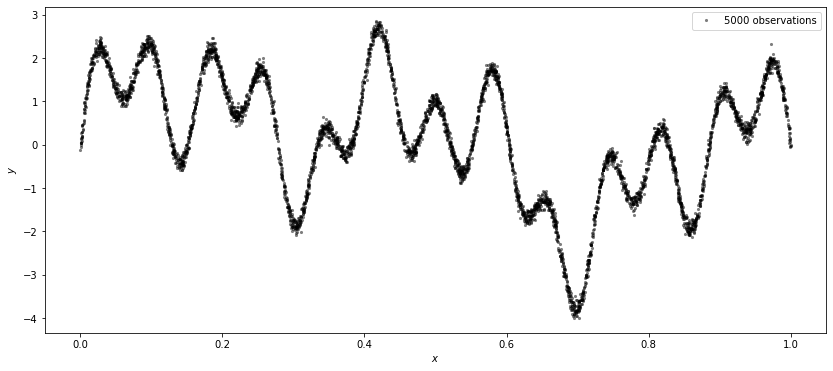

In [33]:
# True latent function
f = lambda x: sum([np.sin(w*np.pi*x) for w in [2, 25, 5, 11]])

N = 5000 # large number of observations

# Random sample locations
X = np.sort(np.random.rand(N)[:,None])
# N noisy observations of the latent function with variance 0.01
y = f(X) + 0.1*np.random.randn(N, 1)

#== Plot samples
plt.figure(figsize=(14, 6))

# Plot points (since there's a lot we make them slightly transparent)
plt.plot(X, y, 'k.', mew=0.1, alpha=0.5)

# Annotate plot
plt.xlabel("$x$"), plt.ylabel("$y$")
plt.legend(labels=["%d observations" % N]);

Clearly, if we tried to fit full GP regression to this, we would face some problems with the sheer computational resources required for matrix inversion in the Gaussian process equations.

We will use a sparse SVGP with a small number of inducing inputs, $m=20$, to try and fit the function. Given the large number of points, we will make some adjustments of the optimiser. We will cap the number of iterations to save time in the lab. These options are given to the `m.optimize()` function. We also add a small amount ($\sigma^2=10^{-6}$) of white noise to our kernel function to avoid any ill-posedness that may occur in the matrix calculations.

We will now fit the sparse SVGP where the inducing inputs of the first model is uniformly sampled throughout the input space and for the second model, inducing inputs are initalises based on the cluster centroids using `scipy.cluster.vq.kmeans`.

In [38]:
# Model 1
# Number of inducing variables
M = 20

# We define M inducing variables sampled uniformly throughout our input space
Z = np.linspace(0., 1., M)[:, None] 
# We assume the covariance to be an RBF, and add a white noise term for numerical stability
k = GPy.kern.RBF(1, lengthscale=0.01, name="rbf") + GPy.kern.White(1, name="white")

# Define a sparse GP with Gaussian likelihood
m = GPy.core.SVGP(
    X, y, Z,
    kernel = k,
    likelihood = GPy.likelihoods.Gaussian()
)

# We define the white noise variance to 10^-6 and fix this
m.kern.white.variance = 1.e-6
m.kern.white.fix()

# We limit the number of iterations here, to limit the maximum runtime
# .. We will also allow the optimiser to print progress messages while it is running
print("Optimising the SVGP Model")
m.optimize(max_iters=2500, messages=1)

# Preview our sparse GP model
m


Optimising the SVGP Model


SVGP.,value,constraints,priors
inducing inputs,"(20, 1)",,
sum.rbf.variance,0.08136435463702536,+ve,
sum.rbf.lengthscale,0.01949084436761818,+ve,
sum.white.variance,1e-06,+ve fixed,
Gaussian_noise.variance,0.5709975173043272,+ve,
q_u_chol,"(210, 1)",,
q_u_mean,"(20, 1)",,


In [39]:
# Model 2
# We define M inducing variables sampled uniformly throughout our input space
Z_km = kmeans(X,M)[0]
# We assume the covariance to be an RBF, and add a white noise term for numerical stability
k_km = GPy.kern.RBF(1, lengthscale=0.01, name="rbf") + GPy.kern.White(1, name="white")

# Define a sparse GP with Gaussian likelihood
m_km = GPy.core.SVGP(
    X, y, Z_km,
    kernel = k_km,
    likelihood = GPy.likelihoods.Gaussian()
)

# We define the white noise variance to 10^-6 and fix this
m_km.kern.white.variance = 1.e-6
m_km.kern.white.fix()

# We limit the number of iterations here, to limit the maximum runtime
# .. We will also allow the optimiser to print progress messages while it is running
print("Optimising the SVGP Model with k means initialisation of the inducing inputs")
m_km.optimize(max_iters=2500, messages=1)

# Preview our sparse GP model
m_km

Optimising the SVGP Model with k means initialisation of the inducing inputs


SVGP.,value,constraints,priors
inducing inputs,"(20, 1)",,
sum.rbf.variance,0.04053833606912016,+ve,
sum.rbf.lengthscale,0.01838699974800736,+ve,
sum.white.variance,1e-06,+ve fixed,
Gaussian_noise.variance,0.06072918757357048,+ve,
q_u_chol,"(210, 1)",,
q_u_mean,"(20, 1)",,


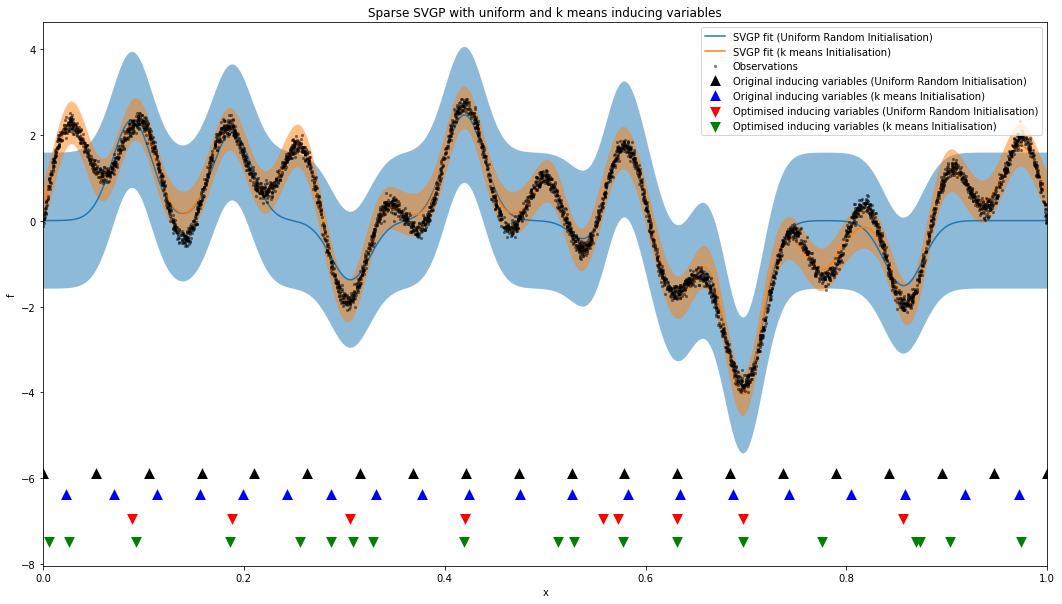

In [40]:
# We create a prediction space defined over the observation space
Xnew = np.linspace(0., 1., 2000)[:, None]

# We predict a likelihood free estimate of our latent functon
mean, Cov = m.predict(Xnew)
# We predict a likelihood free estimate of our latent functon
mean_km, Cov_km = m_km.predict(Xnew)

# Set up figure environment
plt.figure(figsize=(18, 10))

# Plot the sparse GP prediction
plot_gp(Xnew, mean, Cov)
# Plot the sparse GP prediction
plot_gp(Xnew, mean_km, Cov_km)

# Plot observations
plt.plot(X, y, 'k.', mew=0.1, alpha=0.5)

# Plot inducing variable locations
# .. Original inducing variables
plt.plot(Z, [plt.ylim()[0] for _ in Z], 'k^', mew=3)
# .. Original inducing variables
plt.plot(Z_km, [plt.ylim()[0] for _ in Z_km], 'b^', mew=3)
# .. Optimised inducing variables
plt.plot(m.Z, [plt.ylim()[0] for _ in m.Z], 'rv', mew=3)
# Plot inducing variable locations
# .. Optimised inducing variables
plt.plot(m_km.Z, [plt.ylim()[0] for _ in m_km.Z], 'gv', mew=3)

# Annotate plot
plt.xlim((0., 1.))
plt.title("Sparse SVGP with uniform and k means inducing variables")
plt.legend(labels=["SVGP fit (Uniform Random Initialisation)", 
                   "SVGP fit (k means Initialisation)", 
                   "Observations", 
                   "Original inducing variables (Uniform Random Initialisation)", 
                   "Original inducing variables (k means Initialisation)", 
                   "Optimised inducing variables (Uniform Random Initialisation)", 
                   "Optimised inducing variables (k means Initialisation)"]);

As seen above, the choice of the initialisation of the inducing inputs can make a big difference to how well the model is fit to the data.

<h1><u>References and Useful Links</u></h1>

[1] Quiñonero-Candela, Joaquin, and Carl Edward Rasmussen. ‘A Unifying View of Sparse Approximate Gaussian Process Regression’. <I>Journal of Machine Learning Research</I>, vol. 6, no. 65, 2005, pp. 1939–59. www.jmlr.org, http://jmlr.org/papers/v6/quinonero-candela05a.html.<br>
[2] Hensman, James, et al. ‘Gaussian Processes for Big Data’. ArXiv:1309.6835 [Cs, Stat], Sept. 2013. arXiv.org, http://arxiv.org/abs/1309.6835.